# SC3000 Assignment 1
| Name | Matric. No. | Contributions | Percentage |
| ---- | ----------- | ------------- | ---------- |
| BAY YONG WEI NICHOLAS | U2221191A | • Hyperparameter tuning<br>• Analysis of results<br>• Refine notebook presentation | 1/3 |
| JACOB AARON ROSSMAN | U2221082H | • Q-learning agent implementation and research<br>• Cleaning of code<br>• Refine notebook presentation | 1/3 |
| MARTIN NG WEE TECK | U2221959A | • Q-learning agent implementation and research<br>• Cleaning of code, adding comments and markdown<br>• Task 3 implementation | 1/3 |

## Setting up environment

### Installing and importing required packages

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
%pip install gym pyvirtualdisplay > /dev/null 2>&1
%pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
%pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
%pip install --upgrade setuptools 2>&1
%pip install ez_setup > /dev/null 2>&1
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install moviepy
%pip install pygame

# Required dependencies for saving the video frames
%pip install ffmpeg
%pip install imageio-ffmpeg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gym[classic_control]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [81]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import time
import pickle
import itertools

import os
# Set FFMPEG environment variable
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

### Helper function for video playback

In [3]:
def show_video():
    mp4list = glob.glob('./video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                                    loop controls style="height: 400px;">
                                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                                    /video>'''.format(encoded.decode('ascii'))))
    else:
      print("Could not find video")

### Displaying CartPole-v1 environment information and demonstration of how the environment works

In [4]:
env = gym.make("CartPole-v1")
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Env type: {type(env)}")
reset_results = env.reset()
print("Initial observations:", reset_results)

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Env type: <class 'gym.wrappers.time_limit.TimeLimit'>
Initial observations: (array([ 0.04164504,  0.00469123,  0.01057087, -0.00730225], dtype=float32), {})


In [5]:
step_results = env.step(0)

observation = step_results[0]
reward = step_results[1]
done = step_results[2] or step_results[3]

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04173887 -0.19058071  0.01042483  0.2886971 ]
Reward for this step: 1.0
Is this round done? False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [15]:
observation = env.reset()
cumulative_reward = 0
done = False

while not done:
    step_results = env.step(0)

    observation = step_results[0]
    reward = step_results[1]
    done = step_results[2] or step_results[3]
    
    cumulative_reward += reward
    
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


### Our approach

We have decided to go with an epsilon-greedy Q-learning agent to tackle the CartPole problem.

Since we need to maintain a Q-table for the learning, we first need to discretize the states of the environment since the state elements are all real numbers, giving rise to too many unique states.

We also have to determine the learning rate α, discount rate γ, exploration rate ε which will have a decay factor to allow agent to focus on exploiting the best actions towards its final episodes.

The Q-value update formula is as follows:

$$
Q(s,a)=Q(s,a)+α⋅[r+γ⋅max_{a'}Q(s',a')-Q(s,a)]
$$

where
- Q(s,a) is the current Q-value,
- max Q(s',a') is the maximum Q-value for the next state, and
- r is the reward.

## Task 1: Developing RL agent

### Definition and implementation of reinforcement learning (RL) agent using Q-learning

Documentation for each method is included.

In [117]:
class QLearningAgent:
    """
    A class to represent a Q-Learning agent.

    Attributes:
    env -  CartPole environment
    alpha - Learning rate
    gamma - Discount rate
    epsilon - Parameter for epsilon-greedy (determines if agent exploits mroe or explores more)
    no_of_episodes - Total number of simulation episodes
    no_of_bins - Number of bins for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity
    lower_bounds - Lower limits for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity
    upper_bounds - Upper limits for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity
    sum_of_rewards_per_ep - List of sum of rewards in every learning episode
    Qmatrix - Action-value function matrix
    """

    def __init__(self, env, alpha, gamma, epsilon, no_of_episodes, no_of_bins, lower_bounds, upper_bounds):
        """
        Constructs all the necessary attributes for the Q-_earning_Agent object.

        Parameters:
        env (CartPole environment) - CartPole environment
        alpha (float) - Learning rate
        gamma (float) - Discount rate
        epsilon (float) - Parameter for epsilon-greedy (determines if agent exploits mroe or explores more)
        no_of_episodes (int) - Total number of simulation episodes
        no_of_bins (list) - Number of bins for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity
        lower_bounds (list) - Lower limits for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity
        upper_bounds (list) - Upper limits for discretization, list with 4 entries for cart position, cart velocity, pole angle, pole angular velocity

        Returns:
        None
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actionNumber = env.action_space.n
        self.no_of_episodes = no_of_episodes
        self.no_of_bins = no_of_bins
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds

        # List to store all rewards per episode
        self.episode_rewards=[]

        # Action value function matrix
        # Initialized to random values to aid in exploration by starting with some random knowledge
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(no_of_bins[0],no_of_bins[1],no_of_bins[2],no_of_bins[3],self.actionNumber))


    def return_state_index(self,state):
        """
        Returns the index of the state in the Qmatrix.

        For the given 4-dimensional state, and discretization grid defined by
        no_of_bins, lower_bounds, and upper_bounds, this function will return
        the 4D index tuple that is used to index entries of Qmatrix.

        Parameters:
        state (list/array) - 4 entries: cart position, cart velocity, pole angle, and pole angular velocity

        Returns:
        4D tuple - Indices of the Qmatrix that correspond to the input state
        """

        position = state[0]
        velocity = state[1]
        angle = state[2]
        angularVelocity = state[3]

        cartPositionBin = np.linspace(self.lower_bounds[0],self.upper_bounds[0],self.no_of_bins[0])
        cartVelocityBin = np.linspace(self.lower_bounds[1],self.upper_bounds[1],self.no_of_bins[1])
        poleAngleBin = np.linspace(self.lower_bounds[2],self.upper_bounds[2],self.no_of_bins[2])
        poleAngleVelocityBin = np.linspace(self.lower_bounds[3],self.upper_bounds[3],self.no_of_bins[3])

        # All index will have a minimum value of 0 and -1 is to ensure the index from np.digitize starts from 0
        indexPosition=np.maximum(np.digitize(position,cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(velocity,cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(angle,poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(angularVelocity,poleAngleVelocityBin)-1,0)

        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])


    def select_action(self,state,index=-1):
        """
        Selects an action based on the current state.

        Parameters:
        state (list/array) - State for which to compute the action
        index (int) - Index of the current episode, defaulted to -1 for single episode runs

        Returns:
        int - Action selected based on the current state
        """

        if index == -1:
            # For single episodes, do nothing
            pass
        elif 0 <= index < 500:
            # Select completely random actions for exploration in the first 500 episodes
            return np.random.choice(self.actionNumber)
        elif index > 3000:
            # Decrease epsilon parameter for more exploitation after 3000 episodes
            self.epsilon = 0.99 * self.epsilon

        random_number = np.random.random()

        if random_number <= self.epsilon:
            # Exploring with random action (probability = epsilon)
            return np.random.choice(self.actionNumber)
        else:
            # Exploiting with best action (probability = 1 - epsilon)

            # self.Qmatrix[self.return_state_index(state)] returns a 1D np array containing the Q-values for each action in that state.
            # np.max returns the max Q-value of both actions.
            # np.where returns a tuple containing the array of indexes that satisfies the condition. We use [0] to extract that array.
            # Since there could be more than one index for max Q-value in this array, we use random.choice to select a random index.
            return np.random.choice(np.where(self.Qmatrix[self.return_state_index(state)] == np.max(self.Qmatrix[self.return_state_index(state)]))[0])


    def simulate_training_episodes(self, print_results=True):
        """
        Simulates learning/training episodes.

        Parameters:
        print_results (bool) - Boolean to print results of every 250 episodes for tracking progress

        Returns:
        None
        """

        for ep_index in range(1, self.no_of_episodes+1):
            # List to store rewards per episode
            rewardsEpisode=[]

            # Reset environment at start of episode
            state = list(self.env.reset()[0])
            # state=self.env.reset()
            # state=list(state)

            # Track every 250 training episodes
            if ep_index % 250 == 0 and print_results:
                print(f"Simulating episode {ep_index}...")

            # Simulate episode to completion
            done = False
            while not done:
                # Discretized index of state
                stateIndex=self.return_state_index(state)

                # Select action based on current state
                action = self.select_action(state,ep_index)

                # Step into next state with chosen action
                # next_state - Next state
                # reward - Reward from taken step
                # done - Boolean; has terminal state been reached?
                step_results = self.env.step(action)
                
                next_state = step_results[0]
                reward = step_results[1]
                done = step_results[2] or step_results[3]

                rewardsEpisode.append(reward)

                next_state=list(next_state)

                next_stateIndex=self.return_state_index(next_state)

                # return the max value from the 1d array for the next state
                Qmax=np.max(self.Qmatrix[next_stateIndex])

                if not done:
                    # state+(action,) - we use this notation to append the tuples
                    # for example, for state=(0,0,0,1) and action=(1,)
                    # we have state+(action,)=(0,0,0,1,1) which will serve to index the np array Qmatrix

                    # error corresponds to the second part of the Q-learning update formula, without multiplying by alpha
                    error=reward+self.gamma*Qmax-self.Qmatrix[stateIndex+(action,)]
                    # alpha*error together with current Q-value forms the update formula
                    self.Qmatrix[stateIndex+(action,)]=self.Qmatrix[stateIndex+(action,)]+self.alpha*error
                else:
                    # in the terminal state, since there will be no further action taken, there is no reward so the Q-value of terminal state is 0
                    error=reward-self.Qmatrix[stateIndex+(action,)]
                    self.Qmatrix[stateIndex+(action,)]=self.Qmatrix[stateIndex+(action,)]+self.alpha*error

                # set the current state to the next state
                state = next_state

            # Track every 250 training episodes
            if ep_index % 250 == 0 and print_results:
                print(f"Episode reward: {np.sum(rewardsEpisode)}")

            self.episode_rewards.append(np.sum(rewardsEpisode))


    def run_episode(self):
        """
        Runs an episode using trained agent without updates to Qmatrix (used in Task 2).

        Returns:
        int - Total rewards obtained in the episode
        """

        state = list(self.env.reset()[0])
        episode_reward = 0
        done = False

        while not done:
            action = self.select_action(state)

            step_results = self.env.step(action)
            next_state = step_results[0]
            step_reward = step_results[1]
            done = step_results[2] or step_results[3]
            
            episode_reward += step_reward

            next_state = list(next_state)

            state = next_state

        return episode_reward
    

    def run_episode_with_rendering(self):
        """
        Runs an episode using trained agent without updates to Qmatrix and with rendering (used in Task 3).

        Returns:
        int - Total rewards obtained in the episode
        """

        episode_reward = 0
        done = False

        vid_env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./video")
        state = list(vid_env.reset()[0])
        
        self.set_env(vid_env)

        while not done:
            action = self.select_action(state)

            step_results = vid_env.step(action)
            next_state = step_results[0]
            step_reward = step_results[1]
            done = step_results[2] or step_results[3]
            
            episode_reward += step_reward

            next_state = list(next_state)

            state = next_state

        vid_env.close_video_recorder()
        vid_env.close()
        
        return episode_reward


    def set_env(self,env):
        """
        Changes the agent environment (used in Task 3).

        Parameters:
        env (CartPole environment) - New CartPole environment

        Returns:
        None
        """

        self.env=env


    def evaluate(self):
        """
        Evaluates the agent's performance by calculating the average rewards obtained in all episodes.

        Returns:
        float - Average rewards obtained in all episodes
        """

        return sum(self.episode_rewards) / len(self.episode_rewards)

### Creating environment

In [8]:
# Creating environment
env = gym.make('CartPole-v1')
state = env.reset()

### Defining lower, upper bound and number of bins to discretize the states.

Here we obtain the upper and lower bounds for state elements that doo not go to infinity.

As for state elements that go to infinity, we define the bounds ourselves.

In [29]:
# Defining parameters for state discretization
upper_bounds = env.observation_space.high
lower_bounds = env.observation_space.low
cartVelocityMin = -3
cartVelocityMax = 3
poleAngleVelocityMin = -10
poleAngleVelocityMax = 10
upper_bounds[1]=cartVelocityMax
upper_bounds[3]=poleAngleVelocityMax
lower_bounds[1]=cartVelocityMin
lower_bounds[3]=poleAngleVelocityMin

position_bins = 30
velocity_bins = 30
angle_bins = 30
angular_velocity_bins = 30
no_of_bins = [position_bins, velocity_bins, angle_bins, angular_velocity_bins]

### Tuning agent's hyperparameters

We tune the agent's hyperparameters through trial and error to determine the best set to use.

The agent will be assessed by its average reward over 1000 rounds.

In [30]:
# Search space
alphas = [0.1, 0.01]
gammas = [0.99, 0.999]
epsilons = [0.1, 0.2]

param_grid = itertools.product(alphas, gammas, epsilons)

best_performance = float('-inf')
best_hyperparameters = None
no_of_test_episodes = 3000

for params in param_grid:
    test_env = gym.make('CartPole-v1')
    state = test_env.reset()
    alpha, gamma, epsilon = params

    # Initialize agent with current hyperparameters
    agent = QLearningAgent(test_env, alpha, gamma, epsilon, no_of_test_episodes, no_of_bins, lower_bounds, upper_bounds)

    # Train the agent
    agent.simulate_training_episodes(print_results=False)

    # Evaluate performance
    performance = agent.evaluate()

    # Output performance of current hyperparameters
    print("Hyperparameters (alpha, gamma, epsilon):", params)
    print("Avg. Reward per Episode:", performance)

    # Update best_hyperparameters if current performance is better
    if performance > best_performance:
        best_performance = performance
        best_hyperparameters = params

# Best set of hyperparameters and its performance
print("\nBest Hyperparameters:", best_hyperparameters)
print("Avg. Reward per Episode:", best_performance)

Hyperparameters (alpha, gamma, epsilon): (0.1, 0.99, 0.1)
Avg. Reward per Episode: 95.98133333333334
Hyperparameters (alpha, gamma, epsilon): (0.1, 0.99, 0.2)
Avg. Reward per Episode: 94.48866666666666
Hyperparameters (alpha, gamma, epsilon): (0.1, 0.999, 0.1)
Avg. Reward per Episode: 100.89133333333334
Hyperparameters (alpha, gamma, epsilon): (0.1, 0.999, 0.2)
Avg. Reward per Episode: 95.92566666666667
Hyperparameters (alpha, gamma, epsilon): (0.01, 0.99, 0.1)
Avg. Reward per Episode: 45.79366666666667
Hyperparameters (alpha, gamma, epsilon): (0.01, 0.99, 0.2)
Avg. Reward per Episode: 54.705
Hyperparameters (alpha, gamma, epsilon): (0.01, 0.999, 0.1)
Avg. Reward per Episode: 38.678666666666665
Hyperparameters (alpha, gamma, epsilon): (0.01, 0.999, 0.2)
Avg. Reward per Episode: 52.11666666666667

Best Hyperparameters: (0.1, 0.999, 0.1)
Avg. Reward per Episode: 100.89133333333334


**Analysis of Best Hyperparameters**

- Learning rate, ɑ = 0.1. A high learning rate and allows our agent to quickly update its Q-values based on new information.
- Discount factor, γ = 0.999. A high discount factor means that our agent heavily values future rewards over immediate rewards. This allows our agent to perform better and hit the maximum reward ceiling of 500 more consistently.
- Epsilon, ε = 0.1. A low epsilon allows our agent to prioritize exploitation over exploration, meaning it is more likely to stick to its tried and tested strategy of choice.

### Creating and training agent

We create the agent using the class we defined above and train it over 10000 episodes.

Some intermediate results are displayed for observation.

In [86]:
# Train agent for 10000 episodes
alpha, gamma, epsilon = best_hyperparameters
no_of_episodes = 10000
trained_agent = QLearningAgent(env, alpha, gamma, epsilon, no_of_episodes, no_of_bins, lower_bounds, upper_bounds)
trained_agent.simulate_training_episodes()

Simulating episode 250...
Episode reward: 11.0
Simulating episode 500...
Episode reward: 88.0
Simulating episode 750...
Episode reward: 41.0
Simulating episode 1000...
Episode reward: 58.0
Simulating episode 1250...
Episode reward: 127.0
Simulating episode 1500...
Episode reward: 209.0
Simulating episode 1750...
Episode reward: 139.0
Simulating episode 2000...
Episode reward: 82.0
Simulating episode 2250...
Episode reward: 122.0
Simulating episode 2500...
Episode reward: 126.0
Simulating episode 2750...
Episode reward: 77.0
Simulating episode 3000...
Episode reward: 65.0
Simulating episode 3250...
Episode reward: 178.0
Simulating episode 3500...
Episode reward: 160.0
Simulating episode 3750...
Episode reward: 322.0
Simulating episode 4000...
Episode reward: 167.0
Simulating episode 4250...
Episode reward: 360.0
Simulating episode 4500...
Episode reward: 150.0
Simulating episode 4750...
Episode reward: 500.0
Simulating episode 5000...
Episode reward: 500.0
Simulating episode 5250...
Epi

### Visualize agent performance across all training episodes

We plot a graph of reward against episode to assess how the agent's performance changes throughout its training.

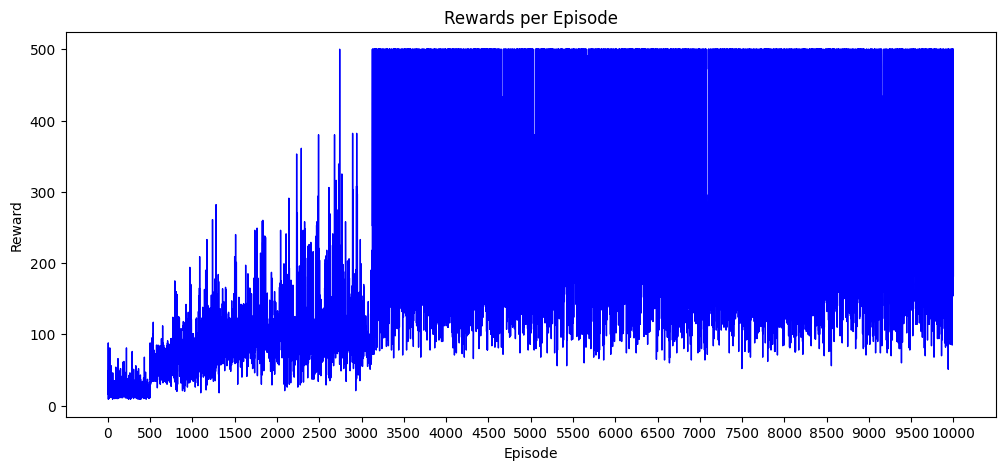

In [114]:
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(trained_agent.episode_rewards, color='blue', linewidth=1)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.xticks(np.arange(0, 10001, 500))
plt.ylabel('Reward')
plt.show()

**Observations**

- Overall, agent's performance increased throughout its training, with noticeable jumps around episodes 500 and 3000. We believe these jumps are due to encouraging our agent to explore and exploit respectively.

- From our agent's select_action() method,
<br>
    ```
    if index == -1:
        # For single episodes, do nothing
        pass
    elif 0 <= index < 500:
        # Select completely random actions for exploration in the first 500 episodes
        return np.random.choice(self.actionNumber)
    elif index > 3000:
        # Decrease epsilon parameter for more exploitation after 3000 episodes
        self.epsilon = 0.99 * self.epsilon
    ```
<br>

- Given that episodes 0 to 499 are designed to encourage agent exploration through completely random actions, it stands to reason that the increase in agent performance past episode 500 is due to the agent being able to exploit the best strategies that it picked up from the earlier episodes.

- Given that episodes past 3000 are designed to encourage agent exploitation through epsilon decay, it stands to reason that there is a substantial increase in agent performance past episode 3000 as the agent can now make full use of its "experience" in the earlier episodes to exploit the best strategies that it had discovered.

- *Exploration refers to having the agent take random actions to explore its environment, which is what we aimed to achieve in the first 500 episodes.*

- *Exploitation refers to having the agent leverage its known strategies in order to maximize rewards. We believed that, past episode 3000, our agent would have understood its environment well enough to have formulated a strategy that could help it maximise its rewards.*

For Task 1, the state and chosen action are shown below:

In [88]:
state = list(env.reset()[0])
action = trained_agent.select_action(state)
print("State:", state)
print("Chosen action:", action)

State: [-0.025303645, 0.044244558, -0.041641288, 0.04061137]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

### Simulate 100 episodes with trained RL agent

Here we use the trained RL agent to play the game across 100 episodes, recording the cumulative reward obtained each round.

In [94]:
episode_results = []
episodeNumber = 100

for episode in range(episodeNumber):
    print(f"Episode: {episode+1}")
    reward = trained_agent.run_episode()
    print(f"Reward: {reward}\n")
    episode_results.append(reward)

Episode: 1
Reward: 500.0

Episode: 2
Reward: 378.0

Episode: 3
Reward: 500.0

Episode: 4
Reward: 500.0

Episode: 5
Reward: 452.0

Episode: 6
Reward: 396.0

Episode: 7
Reward: 500.0

Episode: 8
Reward: 288.0

Episode: 9
Reward: 488.0

Episode: 10
Reward: 262.0

Episode: 11
Reward: 340.0

Episode: 12
Reward: 174.0

Episode: 13
Reward: 304.0

Episode: 14
Reward: 500.0

Episode: 15
Reward: 148.0

Episode: 16
Reward: 402.0

Episode: 17
Reward: 158.0

Episode: 18
Reward: 500.0

Episode: 19
Reward: 500.0

Episode: 20
Reward: 164.0

Episode: 21
Reward: 126.0

Episode: 22
Reward: 184.0

Episode: 23
Reward: 414.0

Episode: 24
Reward: 426.0

Episode: 25
Reward: 500.0

Episode: 26
Reward: 500.0

Episode: 27
Reward: 488.0

Episode: 28
Reward: 116.0

Episode: 29
Reward: 358.0

Episode: 30
Reward: 148.0

Episode: 31
Reward: 160.0

Episode: 32
Reward: 500.0

Episode: 33
Reward: 136.0

Episode: 34
Reward: 500.0

Episode: 35
Reward: 260.0

Episode: 36
Reward: 104.0

Episode: 37
Reward: 270.0

Episode: 3

### Plot graph of Cumulative Reward against Episode

We plot the graph to visualize the agent's rewards for each simulated episode.

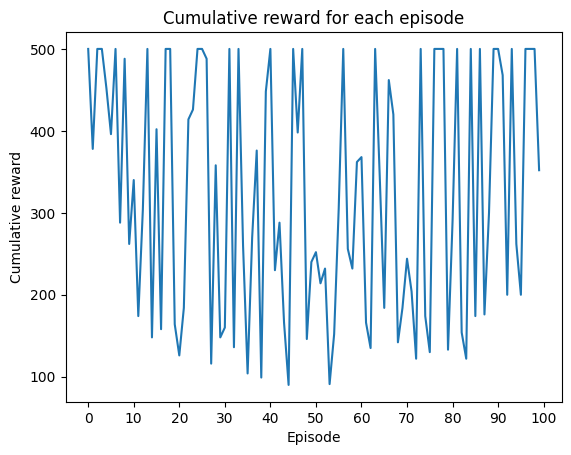

In [95]:
episode_results_np = np.array(episode_results)
plt.plot(episode_results_np)
plt.title('Cumulative reward for each episode')
plt.xlabel('Episode')
plt.xticks(np.arange(0, 101, 10))
plt.ylabel('Cumulative reward')
plt.show()

In [93]:
print("Average cumulative reward:", episode_results_np.mean())
print("Is my agent good enough?", episode_results_np.mean() > 195)

Average cumulative reward: 280.67
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [113]:
episode_reward = trained_agent.run_episode_with_rendering()
show_video()
print("Episode reward:", episode_reward)

Moviepy - Building video /Users/nicholas/Desktop/Nicholas/NTU/Y2S2/SC3000/Labs/Assignment1/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/nicholas/Desktop/Nicholas/NTU/Y2S2/SC3000/Labs/Assignment1/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/nicholas/Desktop/Nicholas/NTU/Y2S2/SC3000/Labs/Assignment1/video/rl-video-episode-0.mp4


Episode reward: 380.0
